In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


function ClickConnect(){
console.log("Working");
document.querySelector('span.file-tree-name[title="video"]').click();
}setInterval(ClickConnect,1000)

#라이브러리

In [ ]:
import cv2, glob, tqdm, json, time, os, random, shutil, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import concurrent.futures

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 경로, 데이터셋 로드

In [ ]:
root_path = '/content/drive/MyDrive/fitness'
copy_path = '/content'

In [ ]:
classes = ["프런트 레이즈",
           "업라이트로우",
           "바벨 스티프 데드리프트",
           "바벨 로우",
           "덤벨 벤트오버 로우",
           "바벨 데드리프트",
           "바벨 스쿼트",
           "오버 헤드 프레스",
           "사이드 레터럴 레이즈",
           "바벨 컬 ",
           "덤벨 컬",
           "덤벨 풀 오버"]

palette = [(255, 165, 0),(0, 128, 0),(128, 0, 128),(255, 0, 255),(0, 0, 128),(128, 128, 0),(0, 0, 255),(165, 42, 42),(0, 255, 255),(255, 192, 203),(70, 130, 90),(255, 99, 71),(0, 128, 128),(255, 0, 0),(0, 255, 0),(0, 0, 0),(255, 255, 255),(128, 128, 128),(210, 105, 30),(218, 165, 32),(173, 216, 230),(255, 20, 147),(0, 255, 127),(220, 20, 60)]
point_name = ['Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear', 'Left Shoulder', 'Right Shoulder', 'Left Elbow', 'Right Elbow', 'Left Wrist', 'Right Wrist', 'Left Hip', 'Right Hip', 'Left Knee', 'Right Knee', 'Left Ankle', 'Right Ankle', 'Neck', 'Left Palm', 'Right Palm', 'Back', 'Waist', 'Left Foot', 'Right Foot']
linked_name =  [["Left Ear","Left Eye"],["Left Eye","Nose"],["Right Ear","Right Eye"],["Right Eye","Nose"],["Nose","Neck"],["Left Palm","Left Wrist"],["Left Wrist","Left Elbow"],["Left Elbow","Left Shoulder"],["Left Shoulder","Neck"],["Right Palm","Right Wrist"],["Right Wrist","Right Elbow"],["Right Elbow","Right Shoulder"],["Right Shoulder","Neck"],["Neck","Back"],["Back","Waist"],["Left Foot","Left Ankle"],["Left Ankle","Left Knee"],["Left Knee","Left Hip"],["Left Hip","Waist"],["Right Foot","Right Ankle"],["Right Ankle","Right Knee"],["Right Knee","Right Hip"],["Right Hip","Waist"]]

for i in range(len(linked_name)):
    linked_name[i][0] = point_name.index(linked_name[i][0])
    linked_name[i][1] = point_name.index(linked_name[i][1])

In [ ]:


dataset = [[[],[],[],[],[]] for _ in range(len(classes))]
error = []

worker = 64
def load_file(filename):
    with open(filename) as f:
        label_json = json.load(f)
        for view in range(5):
            if len(label_json['frames']) != 0 and label_json['type_info']['exercise'] in classes :
                # 경로 Crop
                path_parts = filename.split("/")
                cropped_path = ("/".join(path_parts[:filename.count('/')-1])).replace("label","video")
                minx=1920
                miny=1080
                maxx=0
                maxy=0

                video_path = os.path.dirname(cropped_path + '/' + label_json['frames'][0][f'view{view+1}']['img_key'])+'.avi'
                tmp = [video_path,label_json['type_info']['exercise'],[],[],
                       label_json['type_info']['type'],label_json['type_info']['pose'],filename]
                # tmp = [video_path,label_json['type_info']['exercise'],label_json['type_info']['type'],[],[],label_json['type_info']['pose'],filename]
                for frame in range(len(label_json['frames'])):
                    pts_list = []
                    # 좌표 추가
                    for p in point_name:
                        pts_list.append([label_json['frames'][frame][f'view{view+1}']['pts'][p]['x'],
                                        label_json['frames'][frame][f'view{view+1}']['pts'][p]['y']])
                        minx = min(minx,label_json['frames'][frame][f'view{view+1}']['pts'][p]['x'])
                        miny = min(miny,label_json['frames'][frame][f'view{view+1}']['pts'][p]['y'])
                        maxx = max(maxx,label_json['frames'][frame][f'view{view+1}']['pts'][p]['x'])
                        maxy = max(maxy,label_json['frames'][frame][f'view{view+1}']['pts'][p]['y'])
                    tmp[3].append(pts_list)
                tmp[2] = [minx,miny,maxx,maxy]


                dataset[classes.index(label_json['type_info']['exercise'])][view].append(tmp)
            else :
                error.append([filename,len(label_json['frames']), label_json['type_info']['exercise']])

if os.path.exists(f"{root_path}/dataset/VC.pkl"):
    with open(f"{root_path}/dataset/VC.pkl","rb") as f:
        dataset = pickle.load(f)
else:
    file_list = sorted(glob.glob(f"{root_path}/dataset/*/label/*/*[!d].json"))
    for i in tqdm.tqdm(range(0,len(file_list[:]),worker)):
        with concurrent.futures.ThreadPoolExecutor(max_workers=worker) as executor:
            executor.map(load_file, file_list[i:i+worker])
    with open(f"{root_path}/dataset/VC.pkl","wb") as f:
        pickle.dump(dataset, f)




for i in range(len(classes)):
    print(i, classes[i], len(dataset[i][0]))
    for j in range(5):
        dataset[i][j] = sorted(dataset[i][j])
        if len(dataset[i][j]) != len(dataset[i][j-1]) :
            print(i,j, "error")

print(dataset[0][0][0])
for i in range(len(dataset[0][0][0])):
    print(i,":",dataset[0][0][0][i])

0 프런트 레이즈 352
1 업라이트로우 351
2 바벨 스티프 데드리프트 343
3 바벨 로우 1464
4 덤벨 벤트오버 로우 1654
5 바벨 데드리프트 1592
6 바벨 스쿼트 832
7 오버 헤드 프레스 710
8 사이드 레터럴 레이즈 1436
9 바벨 컬  1437
10 덤벨 컬 1439
11 덤벨 풀 오버 1008
['/content/drive/MyDrive/fitness/dataset/training/video/Day02_200922_F/1/A/193-2-1-09-Z6_A.avi', '프런트 레이즈', [858, 248, 1135, 874], [[[965, 269], [960, 260], [965, 260], [923, 254], [947, 259], [869, 351], [957, 348], [889, 450], [987, 457], [899, 537], [1020, 546], [886, 523], [945, 525], [903, 700], [962, 702], [910, 848], [953, 858], [928, 297], [903, 553], [1022, 565], [925, 406], [921, 479], [925, 857], [976, 869]], [[951, 267], [948, 257], [953, 259], [910, 250], [936, 257], [862, 358], [949, 343], [899, 428], [1023, 430], [971, 501], [1076, 489], [876, 533], [930, 533], [902, 694], [957, 702], [908, 850], [952, 863], [915, 296], [981, 504], [1087, 500], [923, 406], [920, 477], [927, 858], [973, 874]], [[938, 266], [933, 252], [940, 251], [893, 253], [922, 254], [858, 350], [933, 339], [962, 343], [10

# 데이터셋 로컬에 복사

In [ ]:
def copy_tree(lst):
    filename = lst[0]
    shutil.copy(filename,filename.replace(root_path,copy_path))

# 데이터 경로 생성
for cls in range(len(classes)):
    for i in range(5):
        for j in range(len(dataset[cls][i])):
            filename = dataset[cls][i][j][0]
            from_dir = os.path.dirname(filename)+'/'
            to_dir = from_dir.replace(root_path,copy_path)
            if os.path.exists(to_dir)==False:
                os.makedirs(to_dir,exist_ok=True)

#데이터 로컬에 복사
for cls in range(len(classes)):
    for i in tqdm.tqdm(range(5),desc=f"{cls+1}/{len(classes)}({len(dataset[cls][0])})"):
        for j in range(0,len(dataset[cls][i]),worker):
            with concurrent.futures.ThreadPoolExecutor(max_workers=worker) as executor:
                executor.map(copy_tree, dataset[cls][i][j:j+worker])

12/12(1008): 100%|██████████| 5/5 [01:38<00:00, 19.72s/it]


In [ ]:
#dataset 경로 변경
for cls in range(len(classes)):
    for i in range(5):
        for j in range(len(dataset[cls][i])):
            dataset[cls][i][j][0] = dataset[cls][i][j][0].replace(root_path,copy_path)

#데이터셋 설정

In [ ]:
train = []
valid = []
test = []
ratio = 0.2

# for i, inner_list in enumerate(dataset):
#     train += [[item[:-int(len(item)*(ratio*2))] for j,item in enumerate(inner_list)]]
#     valid += [[item[-int(len(item)*(ratio*2)):-int(len(item)*(ratio))] for j,item in enumerate(inner_list)]]
#     test += [[item[-int(len(item)*(ratio)):] for j,item in enumerate(inner_list)]]

for i, inner_list in enumerate(dataset):
    view_train = []
    view_valid = []
    for j in range(5):
        view_train.append([data for k,data in enumerate(inner_list[j]) if k % 5 != 0])
        view_valid.append([data for k,data in enumerate(inner_list[j]) if k % 5 == 0])
    train.append(view_train)
    valid.append(view_valid)

max_num_train = 0
for i in range(len(classes)):
    max_num_train = max(len(train[i][0]), max_num_train)
    print(i, classes[i], len(train[i][0]),len(valid[i][0]))
    #print(i, classes[i], len(train[i][0]),len(valid[i][0]),len(test[i][0]))

0 프런트 레이즈 281 71
1 업라이트로우 280 71
2 바벨 스티프 데드리프트 274 69
3 바벨 로우 1171 293
4 덤벨 벤트오버 로우 1323 331
5 바벨 데드리프트 1273 319
6 바벨 스쿼트 665 167
7 오버 헤드 프레스 568 142
8 사이드 레터럴 레이즈 1148 288
9 바벨 컬  1149 288
10 덤벨 컬 1151 288
11 덤벨 풀 오버 806 202


In [ ]:
# Rare Class ( Over Sampling)
new_train = []

for i, inner_list in enumerate(train):
    new_inner_list = [(item * int(np.ceil(max_num_train/len(item))))[:max_num_train] if len(item) !=0 else [] for j,item in enumerate(inner_list)]
    new_train.append(new_inner_list)


for i in range(len(classes)):
    print(i, classes[i], len(new_train[i][0]))
    for j in range(1,5):
        if len(new_train[i][j]) != len(new_train[i][j-1]) :
            print(i,j, "error")

0 프런트 레이즈 1323
1 업라이트로우 1323
2 바벨 스티프 데드리프트 1323
3 바벨 로우 1323
4 덤벨 벤트오버 로우 1323
5 바벨 데드리프트 1323
6 바벨 스쿼트 1323
7 오버 헤드 프레스 1323
8 사이드 레터럴 레이즈 1323
9 바벨 컬  1323
10 덤벨 컬 1323
11 덤벨 풀 오버 1323


In [ ]:
IMAGE_WIDTH = 192
IMAGE_HEIGHT = 256

In [ ]:


def draw_joint(img,pts,rad=3,line=1):
    out = img.copy()
    h,w,c = img.shape
    used = np.zeros_like(point_name,dtype=np.int32())

    if torch.max(pts) <=1:
        pts = pts * torch.tensor([w,h])

    for i,se in enumerate(linked_name):
        from_xy = (int(pts[se[0]][0]),int(pts[se[0]][1]))
        to_xy = (int(pts[se[1]][0]),int(pts[se[1]][1]))

        out = cv2.line(out,from_xy,to_xy,[255,255,255],line,cv2.LINE_AA)
        if (used[se[0]]==0):
            out= cv2.circle(out,from_xy,rad,palette[se[0]],-1,cv2.LINE_AA)
            used[se[0]] = 1

        if (used[se[1]]==0):
            out= cv2.circle(out,to_xy,rad,palette[se[1]],-1,cv2.LINE_AA)
            used[se[1]] = 1

    return out

def denormalization(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):

    out_img =  img * std  + mean
    return out_img

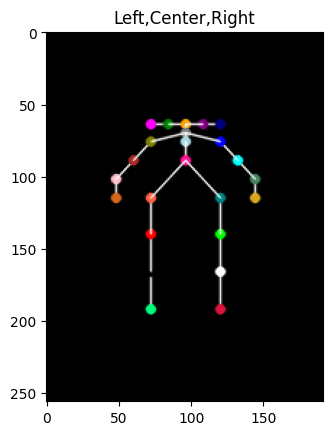

In [ ]:
# 뒤에서 본 신체의 좌표
body_coordinates = [[0.5, 0.25], [0.4375, 0.25], [0.5625, 0.25], [0.375, 0.25], [0.625, 0.25], [0.375, 0.3], [0.625, 0.3], [0.3125, 0.35], [0.6875, 0.35], [0.25, 0.4], [0.75, 0.4], [0.375, 0.45], [0.625, 0.45], [0.375, 0.55], [0.625, 0.55], [0.375, 0.65], [0.625, 0.65], [0.5, 0.275], [0.25, 0.45], [0.75, 0.45], [0.5, 0.3], [0.5, 0.35], [0.375, 0.75], [0.625, 0.75]]
body_coord_visualization = draw_joint(np.zeros((256,192,3)).astype(np.uint8()),torch.tensor(body_coordinates))
img = np.zeros((256,192,3),dtype = np.uint8())
plt.title("Left,Center,Right")
plt.imshow(body_coord_visualization)
plt.show()


In [ ]:
class fitness(Dataset):
    def __init__(self, data, num_frames = 8, views = [2, 3, 4], training = True, frame_mode=1):

        self.data = data

        self.views = [view-1 for view in views]

        self.len_data = 0
        self.idx_list = []
        self.num_frames = num_frames
        self.training = training
        self.frame_mode = frame_mode

        for cls in range(len(classes)):
            for view in self.views:
                for idx in range(len(self.data[cls][view])):
                    if (self.frame_mode<=1):
                        self.idx_list.append([cls,view,idx,-1])
                        self.len_data += 1
                    else:
                        for frame in range(max(1,len(self.data[cls][view][idx][3])-self.num_frames+1)):
                            self.idx_list.append([cls,view,idx,frame])
                            self.len_data += 1

        if training :
            transform_list = [
                A.ColorJitter(p=0.5),
                #A.HorizontalFlip(p=0.5),
                A.Affine(mode=0),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ]
        else :
            transform_list = [A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                              ToTensorV2()]

        additional_targets = {}
        for i in range(1,self.num_frames):
            additional_targets[f'image{i}'] = "image"
            additional_targets[f'keypoints{i}'] = "keypoints"
        self.transforms = A.Compose(transform_list, additional_targets = additional_targets,keypoint_params=A.KeypointParams(format='xy',remove_invisible=False))


    def __len__(self):
        return self.len_data

    def gaussian_heatmap(self, center,img_size = (224,224),sig=5):
        x_axis = np.linspace(0,img_size[0]-1,img_size[0])-center[0]
        y_axis = np.linspace(0,img_size[1]-1,img_size[1])-center[1]
        xx,yy = np.meshgrid(x_axis,y_axis)
        kernel = np.exp(-0.5*(np.square(xx)+np.square(yy))/np.square(sig))
        return kernel #좌표 오버나면 알아서 없애줌

    def __getitem__(self, idx):

        cls_idx, view_idx, data_idx, frame_idx = self.idx_list[idx]

        if self.frame_mode==0:
            frame_idx = 0
        elif self.frame_mode==1:
            if len(self.data[cls_idx][view_idx][data_idx][3])-self.num_frames+1 <= 0:
                frame_idx = 0
            else:
                frame_idx = np.random.randint(0,len(self.data[cls_idx][view_idx][data_idx][3])-self.num_frames+1)

        x1,y1,x2,y2 = self.data[cls_idx][view_idx][data_idx][2]

        #사전에 미리 Crop한 이미지 x1,y1,x2,y2
        crop_min_x = max(0,x1-200)
        crop_min_y = max(0,y1-200)
        crop_max_x = min(1920,x2+200)
        crop_max_y = min(1080,y2+200)


        path = self.data[cls_idx][view_idx][data_idx][0]



        if (os.path.exists(path)==False):
            print(path,"가 없습니다.")

        imgs = []
        coord = []
        cap = cv2.VideoCapture(path)
        for idx in range(frame_idx,frame_idx+self.num_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx*2) # 프레임 시작위치를 idx 프레임으로 옮김
            ret, frame = cap.read()

            if ret == False:
                break

            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame,(IMAGE_WIDTH,IMAGE_HEIGHT))
            imgs.append(frame)
            pts = np.array(self.data[cls_idx][view_idx][data_idx][3][idx]) - [crop_min_x,crop_min_y]
            pts = pts * [IMAGE_WIDTH/(crop_max_x-crop_min_x),IMAGE_HEIGHT/(crop_max_y-crop_min_y)]
            coord.append(pts)
        cap.release()

        imgs = np.array(imgs)
        coord = np.array(coord) # frame,24,2


        if len(imgs) < self.num_frames:
            imgs = np.concatenate([np.zeros((self.num_frames-len(imgs),IMAGE_HEIGHT,IMAGE_WIDTH,3),dtype=np.uint8),imgs],0)
            coord = np.concatenate([np.zeros((self.num_frames-len(imgs),24,2),dtype=np.float32)-255,coord],0)


        input_image = {}
        for i in range(len(imgs)):
            if i == 0:
                input_image['image'] = imgs[0]
                input_image['keypoints'] = coord[0]
            else:
                input_image[f'image{i}'] = imgs[i]
                input_image[f'keypoints{i}'] = coord[i]
        augmentations = self.transforms(**input_image)



        imgs = torch.zeros((self.num_frames,3,IMAGE_HEIGHT,IMAGE_WIDTH),dtype=torch.float32)
        heatmap = np.zeros((self.num_frames,IMAGE_HEIGHT,IMAGE_WIDTH,24),dtype= np.float32)

        imgs[0, :, :, :] = augmentations["image"]
        coord[0, :, :] = augmentations["keypoints"]
        for i in range(1, len(imgs)):
            imgs[i, :, :, :] = augmentations[f"image{i}"]
            coord[i, :, :] = augmentations[f"keypoints{i}"]

        for i in range(self.num_frames):
            for j in range(24):
                heatmap[i,:,:,j] = self.gaussian_heatmap((np.round(coord[i,j,0],0),np.round(coord[i,j,1],0)),(IMAGE_WIDTH,IMAGE_HEIGHT))

        heatmap = torch.from_numpy(heatmap)
        heatmap = torch.permute(heatmap,(0,3,1,2))

        vid_with_heatmap = torch.cat([imgs,heatmap],1)


        dataset = {"idx" : [cls_idx,view_idx, data_idx, frame_idx],
                   "video" : imgs,
                   "video_heatmap" : vid_with_heatmap,
                   "coord" : coord,
                   "class" : classes.index(self.data[cls_idx][view_idx][data_idx][1]),
                   "view" : view_idx,
                   "class_name" : self.data[cls_idx][view_idx][data_idx][1],
                   "type" : self.data[cls_idx][view_idx][data_idx][4],
                   "pose" : self.data[cls_idx][view_idx][data_idx][5],
                   "label_path" : self.data[cls_idx][view_idx][data_idx][6]}


        return dataset



In [ ]:
num_frame = 8
train_set = fitness(new_train, num_frames = num_frame, views = [1, 2, 3, 4, 5])
valid_set = fitness(valid, num_frames = num_frame, views = [1, 2, 3, 4, 5], training =  False, frame_mode=0)
#test_set = fitness(test, num_frames = num_frame, views = [1, 2, 3, 4, 5], training =  False)
print(len(train_set), len(valid_set))
#print(len(train_set), len(valid_set), len(test_set))

79380 12645


In [ ]:

for i in range(5):
    start_time = time.time()
    data= train_set[i]

    print(time.time()-start_time)
    print(data['class_name'])
    frames = torch.permute(data['video'],(0,2,3,1))

    plt.figure(figsize=(5*num_frame,10))

    for j in range(num_frame):
        plt.subplot(1,num_frame,j+1)
        plt.imshow((denormalization(frames[j].numpy())*255).astype(np.uint8))
        plt.title(f"{data['class']}({j})")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

#모델


In [ ]:

class bottleneck_block(nn.Module):
    def __init__(self,i,o,s,e,stage):
        super(bottleneck_block,self).__init__()

        self.conv1 = nn.Conv2d(i,o,1,s)
        self.bn1 = nn.BatchNorm2d(o)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(o,o,3,1,1)
        self.bn2 = nn.BatchNorm2d(o)
        self.conv3 = nn.Conv2d(o,o*e,1,1)
        self.bn3 = nn.BatchNorm2d(o*e)
        if s == 2 or i==o:
          self.identity = nn.Sequential(
              nn.Conv2d(i,o*e,1,s),
              nn.BatchNorm2d(o*e)
          )
        else :
          self.identity = nn.Sequential()

    def forward(self,x):

        identity = self.identity(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)


        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module): #정확성 향상을 위해 resnet 101로도 고려해볼것
    def __init__(self,image_features,e=4,num_layers=[3,4,6,3]): #50 [3,4,6,3]101은 [3,4,23,3 ]152는 [3,8,36,3]
        super(ResNet,self).__init__()
        def n_blocks(i,o,s,stage):
            layers = []
            layers.append(bottleneck_block(i,o,s,e,stage))

            for _ in range(1,num_layers[stage]):
                layers.append(bottleneck_block(o*e,o,1,e,stage))

            return nn.Sequential(*layers)


        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,7,2,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1)
        )

        self.stage1 = n_blocks(64,64,1,0)
        self.stage2 = n_blocks(64*e,128,2,1)
        self.stage3 = n_blocks(128*e,256,2,2)
        self.stage4 = n_blocks(256*e,512,2,3)

        self.F = nn.AdaptiveAvgPool2d(1)

        self.image_features = image_features
        self.bottleneck = nn.Linear(512*e, self.image_features)


    def forward(self,x,cls_label=None):
        b,c,h,w = x.size()

        out = self.conv1(x)

        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        out = self.F(out)

        out = out.view(out.size(0),-1) #(b*t,512*e)

        #out = self.bottleneck(out)

        return {"feature":out}

class Custom_LSTM(nn.Module):
    def __init__(self, image_features=512*4, hidden_size=512, output_size=len(classes), num_layers=1, dropout=0, bidirectional=True):

        if bidirectional:
            self.name = "BI-LSTM"
        else:
            self.name = "Uni-LSTM"
        super(Custom_LSTM, self).__init__()


        self.D = (1 + bidirectional)

        self.num_layers = num_layers

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(image_features, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)

        self.fc = nn.Sequential(
            nn.Linear(self.D*hidden_size, self.D*hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.D*hidden_size, output_size)
        )

        self.extract_from_image = nn.Sequential(
            ResNet(image_features)
        )

        self.embed_hidden = nn.Embedding(5,self.hidden_size)

    def forward(self,x ):
        out = {}
        b, t, c, h, w = x.shape #batch, frame, points, coord
        x = x.view(b*t,c,h,w)

        hidden = self.init_hidden(b, x.device)

        feature = self.extract_from_image(x)
        feature = feature['feature'].view(b,t,-1)
        lstm_out, hidden = self.lstm(feature, hidden)

        out['feature'] = lstm_out[:, -1, :]

        out['class'] = self.fc(out['feature'])

        return out

    # def init_hidden(self,view , device):
    #     hidden = torch.tile(self.embed_hidden(view).unsqueeze(0),(self.D*self.num_layers,1,1))
    #     # batch, -> batch,hidden_size -> 1,batch,hidden_size -> (self.D*self.num_layers,batch,hidden_size
    #     return (hidden,hidden)
    def init_hidden(self,batch_size , device):
        return (torch.zeros(self.D*self.num_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.D*self.num_layers, batch_size, self.hidden_size, device=device))

In [ ]:

class bottleneck_block_tsm(nn.Module):
    def __init__(self,i,o,s,e,stage,frame=8,div=8):
        super(bottleneck_block_tsm,self).__init__()

        self.frame = frame
        self.div = div
        self.conv1 = nn.Conv2d(i,o,1,s)
        self.bn1 = nn.BatchNorm2d(o)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(o,o,3,1,1)
        self.bn2 = nn.BatchNorm2d(o)
        self.conv3 = nn.Conv2d(o,o*e,1,1)
        self.bn3 = nn.BatchNorm2d(o*e)
        if s == 2 or i==o:
          self.identity = nn.Sequential(
              nn.Conv2d(i,o*e,1,s),
              nn.BatchNorm2d(o*e)
          )
        else :
          self.identity = nn.Sequential()

    def shift(self,x,frame=8,div=8):
        bt,c,h,w = x.size()
        b = bt//frame
        t = frame

        div_c = c//div

        x = x.view(b,t,c,h,w)
        ret = torch.zeros_like(x)
        #ret = x.detach().clone()

        #bi-shift
        ret[:,:-1,:div_c,:,:] = x[:,1:,:div_c,:,:]
        ret[:,1:,div_c:div_c*2,:,:] = x[:,:-1,div_c:div_c*2,:,:]
        ret[:,:,div_c*2:,:,:] = x[:,:,div_c*2:,:,:]

        ret = ret.view(bt,c,h,w)
        return ret

    def forward(self,x):

        identity = self.identity(x)
        out = self.shift(x,self.frame,self.div)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)


        out += identity
        out = self.relu(out)

        return out


class ResNet_TSM(nn.Module): #정확성 향상을 위해 resnet 101로도 고려해볼것
    def __init__(self,e=4,num_layers=[3,4,6,3],frame=8,div=8,heatmap=False): #50 [3,4,6,3]101은 [3,4,23,3 ]152는 [3,8,36,3]
        super(ResNet_TSM,self).__init__()
        self.name = "TSM"
        def n_blocks(i,o,s,stage):
            layers = []
            layers.append(bottleneck_block_tsm(i,o,s,e,stage,frame=frame,div=div))

            for _ in range(1,num_layers[stage]):
                layers.append(bottleneck_block_tsm(o*e,o,1,e,stage,frame=frame,div=div))

            return nn.Sequential(*layers)


        self.conv1 = nn.Sequential(
            nn.Conv2d(3+24*heatmap,64,7,2,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1)
        )

        self.stage1 = n_blocks(64,64,1,0)
        self.stage2 = n_blocks(64*e,128,2,1)
        self.stage3 = n_blocks(128*e,256,2,2)
        self.stage4 = n_blocks(256*e,512,2,3)

        self.F = nn.AdaptiveAvgPool2d(1)

        self.FC_cls = nn.Sequential(
            nn.Linear(512*e,len(classes)) #운동 종류들() , 자세(5) ,활동상태(1,s)
        )


    def forward(self,x,cls_label=None):
        b,t,c,h,w = x.size()

        out = x.view(b*t,c,h,w)

        out = self.conv1(out)

        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)

        out = self.F(out)

        out = out.view(out.size(0),-1) #(b*t,512*e)

        out_cls = self.FC_cls(out).view(b,t,-1).mean(1)  # b*t,len(classes) -> b, t, len(classes) -> b, len(classes)

        return {"feature":out, "class":out_cls}

#학습

In [ ]:
def accuracy(pred, label):
    with torch.no_grad():
        _,pred = torch.max(pred, dim=1)
        accuracy = torch.sum(pred==label)/pred.shape[0]
    return accuracy

In [ ]:
def seed_everything(seed: int = 32):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(32)

In [ ]:
if "model" in globals():
    model.cpu()
    torch.cuda.empty_cache()
# model = Custom_LSTM(image_features=2048,
#                     hidden_size=1024,
#                     num_layers=4,
#                     dropout=0, #Dropout을 하기 위해서는 레이어의 수가 2 이상이어야함
#                     bidirectional=True)
#model = ResNet_TSM(num_layers=[3,4,23,3],frame=num_frame)
model = ResNet_TSM(frame=num_frame,heatmap=True)

model_input = ["video_heatmap"]

metrics = {"class":accuracy} # [평가지표, Pred, Label]
criterions = {"class":nn.CrossEntropyLoss()}

min_epoch = 0
learning_status = {
    'train_metrics' : [],
    'valid_metrics' : [],
    'train_losses' : [],
    'valid_losses' : [],
    'lrs' : [],
    'best' : []
}

optimizer = torch.optim.AdamW(params = model.parameters(), lr=5e-5, weight_decay=0.01)

#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,last_epoch=len(learning_status['lrs'])-1, lr_lambda=lambda epoch: 0.95 ** epoch)
# warmup_epochs = 50
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,last_epoch=len(learning_status['lrs'])-1, lr_lambda=lambda epoch: epoch / warmup_epochs)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True, num_workers=16)
valid_loader = DataLoader(valid_set,batch_size=batch_size,shuffle=False, num_workers=16)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
model_save_path = root_path + f'/model/VC/{model.name}(5e-5,heatmap)/' # frame,layers,hidden

model = model.to(device)

epochs = 10


In [ ]:

def train_begin(training,loader,running_loss,running_metric):
    if training :
        desc = "Train"
    else:
        desc = "Valid"

    progress = tqdm.tqdm(loader,desc=f'Epoch:{epoch+1}/{epochs}')
    for i,data in enumerate(progress):


        if (training):
            optimizer.zero_grad()

        pred = model(*[data[key].to(device) for key in model_input])

        total_loss = torch.tensor(0.0).to(device)
        metric = torch.tensor(0.0).to(device)

        loss_list = []
        metric_list = []


        for key in criterions.keys():
            if (type(criterions[key]) == list):
                loss = criterions[key][0](pred[criterions[key][1]],data[criterions[key][2]].to(device))
            else :
                loss = criterions[key](pred[key],data[key].to(device))
            total_loss  = total_loss+loss
            loss_list.append(loss.detach().cpu().numpy())

        for key in metrics.keys():
            if (type(metrics[key]) == list):
                metric = metrics[key][0](pred[metrics[key][1]],data[metrics[key][2]].to(device))
            else :
                metric = metrics[key](pred[key],data[key].to(device))
            metric_list.append(metric.cpu())

        if (training):

            total_loss.backward()

            optimizer.step()

        running_loss += loss_list
        running_metric += metric_list
        progress.set_description(f'Epoch:{epoch+1}/{epochs} | {desc}_Metric{list(metrics.keys())}:{np.round(running_metric/(i+1),5)} | {desc}_Loss{list(criterions.keys())}:{np.round(running_loss/(i+1),5)}')

In [ ]:


print("모델 저장 경로 : "+ model_save_path)
fit_time = time.time()
start_epoch = len(learning_status['lrs'])



for epoch in range(start_epoch,epochs):
    print("모델명 :", model_save_path.split('/')[-2])

    #Warmup Schedule
    # if epoch < warmup_epochs :
    #     scheduler.step()
    #     print("lr이 변경되었습니다.",optimizer.param_groups[0]['lr'])


    # scheduler.step()
    # print("lr이 변경되었습니다.",optimizer.param_groups[0]['lr'])


    running_train_loss = np.zeros((len(criterions.keys())))
    running_valid_loss = np.zeros((len(criterions.keys())))

    running_train_metric = np.zeros((len(metrics.keys())))
    running_valid_metric = np.zeros((len(metrics.keys())))


    model.train()
    train_begin(True,train_loader,running_train_loss,running_train_metric)
    model.eval()
    with torch.no_grad():
        train_begin(False,valid_loader,running_valid_loss,running_valid_metric)


    learning_status['train_losses'].append((running_train_loss/len(train_loader)))
    learning_status['valid_losses'].append((running_valid_loss/len(valid_loader)))
    learning_status['train_metrics'].append((running_train_metric/len(train_loader)))
    learning_status['valid_metrics'].append((running_valid_metric/len(valid_loader)))
    learning_status['lrs'].append(optimizer.param_groups[0]['lr'])

    checkpoint = {
        'epoch': epoch+1 , #에폭
        'model': model.state_dict(),  # 모델
        'optimizer': optimizer.state_dict()  # 옵티마이저
    }
    if "scheduler" in globals():
        checkpoint['scheduler'] = scheduler.state_dict()  # 스케줄러

    if os.path.exists(model_save_path) == False:
        os.makedirs(model_save_path,exist_ok=True)


    if sum(learning_status['valid_losses'][min_epoch]) >= sum(learning_status['valid_losses'][-1]) and sum(learning_status['valid_losses'][-1] > 0):
        print(f"Valid Loss가 최소가 됐습니다. ({sum(learning_status['valid_losses'][min_epoch]):.5f}({min_epoch+1}) -> {sum(learning_status['valid_losses'][-1]):.5f}({len(learning_status['valid_losses'])}))")
        print(f'해당 모델이 {model_save_path}Best{epoch+1}.pth 경로에 저장됩니다.')
        min_epoch = len(learning_status['valid_losses'])-1
        torch.save(checkpoint, model_save_path+f'Best{epoch+1}.pth')
        learning_status['best'].append(sum(learning_status['valid_losses'][-1]))
    else:
        print(f"Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:{min_epoch+1} : {sum(learning_status['valid_losses'][min_epoch]):.5f}, 현재 : {sum(learning_status['valid_losses'][-1]):.5f})")
        learning_status['best'].append('False')

    torch.save(checkpoint, model_save_path+f'Last{epoch+1}.pth')

    df = pd.DataFrame(learning_status)
    df.to_csv(model_save_path+'status.csv', index=True)

    print('')


print('학습 최종 시간: {:.2f} 분\n' .format((time.time()- fit_time)/60))

모델 저장 경로 : /content/drive/MyDrive/fitness/model/VC/TSM(5e-5,heatmap)/
모델명 : TSM(5e-5,heatmap)


Epoch:7/10 | Train_Metric['class']:[0.98379] | Train_Loss['class']:[0.04705]: 100%|██████████| 4962/4962 [3:31:43<00:00,  2.56s/it]
Epoch:7/10 | Valid_Metric['class']:[0.98902] | Valid_Loss['class']:[0.03846]: 100%|██████████| 791/791 [28:03<00:00,  2.13s/it]


Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:6 : 0.03684, 현재 : 0.03846)

모델명 : TSM(5e-5,heatmap)


Epoch:8/10:   0%|          | 0/4962 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:8/10 | Train_Metric['class']:[0.9854] | Train_Loss['class']:[0.04207]: 100%|██████████| 4962/4962 [3:39:39<00:00,  2.66s/it]
Epoch:8/10 | Valid_Metric['class']:[0.98831] | Valid_Loss['class']:[0.03732]: 100%|██████████| 791/791 [27:35<00:00,  2.09s/it]


Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:6 : 0.03684, 현재 : 0.03732)

모델명 : TSM(5e-5,heatmap)


Epoch:9/10:   0%|          | 0/4962 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:9/10 | Train_Metric['class']:[0.98723] | Train_Loss['class']:[0.03685]: 100%|██████████| 4962/4962 [3:25:09<00:00,  2.48s/it]
Epoch:9/10 | Valid_Metric['class']:[0.98997] | Valid_Loss['class']:[0.03337]: 100%|██████████| 791/791 [27:54<00:00,  2.12s/it]


Valid Loss가 최소가 됐습니다. (0.03684(6) -> 0.03337(9))
해당 모델이 /content/drive/MyDrive/fitness/model/VC/TSM(5e-5,heatmap)/Best9.pth 경로에 저장됩니다.

모델명 : TSM(5e-5,heatmap)


Epoch:10/10:   0%|          | 0/4962 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Epoch:10/10 | Train_Metric['class']:[0.98778] | Train_Loss['class']:[0.03519]: 100%|██████████| 4962/4962 [3:30:11<00:00,  2.54s/it]
Epoch:10/10 | Valid_Metric['class']:[0.9868] | Valid_Loss['class']:[0.04822]: 100%|██████████| 791/791 [28:09<00:00,  2.14s/it]


Valid_Loss가 최소가 되지 못했습니다.(최소 Epoch:9 : 0.03337, 현재 : 0.04822)

학습 최종 시간: 958.61 분



# T-SNE 시각화

In [ ]:
!tree

/bin/bash: line 1: tree: command not found


In [ ]:

from sklearn.manifold import TSNE


In [ ]:
# model = Custom_LSTM(image_features=2048,
#                     hidden_size=1024,
#                     num_layers=4,
#                     dropout=0, #Dropout을 하기 위해서는 레이어의 수가 2 이상이어야함
#                     bidirectional=True)

# model_save_path = f'{root_path}/model/VC/{model.name}(2048,1024,4,5e-5)'

#model = ResNet_TSM(num_layers=[3,4,23,3],frame=num_frame)
model = ResNet_TSM(frame=num_frame,heatmap=True)
model_save_path = f'{root_path}/model/VC/{model.name}(5e-5,heatmap)'

In [ ]:
model.load_state_dict(torch.load(f'{model_save_path}/Last9.pth')['model'])
model.to(device)
model.eval()

ResNet_TSM(
  (conv1): Sequential(
    (0): Conv2d(27, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): bottleneck_block_tsm(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (identity): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1

In [ ]:
batch_size = 16
num_frames=8
tsne_valid_set = fitness(valid, num_frames = num_frames, views = [1, 2, 3, 4, 5], training =  False, frame_mode=2)
tsne_valid_loader = DataLoader(tsne_valid_set,batch_size=batch_size,shuffle=False, num_workers=16)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
features = []
cls_probs = []
true_labels = []

progress = tqdm.tqdm(tsne_valid_loader,desc=f'Pred')
with torch.no_grad() :
    for i,data in enumerate(progress):
        output = model(data['video_heatmap'].to(device))

        feature = output['feature'].cpu().detach().numpy()

        cls_prob = output['class'].cpu().detach().numpy()

        b,c = cls_prob.shape

        if (model.name == "TSM"):
            feature = np.mean(feature.reshape(b,num_frames,-1),1)

        for j in range(b):
            features.append(feature[j])
            cls_probs.append(cls_prob[j])
            true_labels.append(data['class'][j].numpy())

features = np.array(features)
cls_probs = np.array(cls_probs)
true_labels = np.array(true_labels)

np.save(f'{model_save_path}/features',features)
np.save(f'{model_save_path}/cls_probs',cls_probs)
np.save(f'{model_save_path}/true_labels',true_labels)

Pred: 100%|██████████| 7096/7096 [4:26:17<00:00,  2.25s/it]


In [ ]:
features = np.load(f'{model_save_path}/features.npy')
cls_probs = np.load(f'{model_save_path}/cls_probs.npy')
true_labels = np.load(f'{model_save_path}/true_labels.npy')
cls = np.argmax(cls_probs,-1)


## 전체 클래스 시각화

In [ ]:
# features는 T-SNE를 적용하고자 하는 특정 모델의 feature 벡터입니다.
random_state = 42

if os.path.exists(f'{model_save_path}/tsne_{random_state}.npy'):
    tsne_result = np.load(f'{model_save_path}/tsne_{random_state}.npy')
else:
    start_time = time.time()
    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_result = tsne.fit_transform(features)
    print((time.time()-start_time)/60,"분")
    np.save(f'{model_save_path}/tsne_{random_state}',tsne_result)

13.044764184951783 분


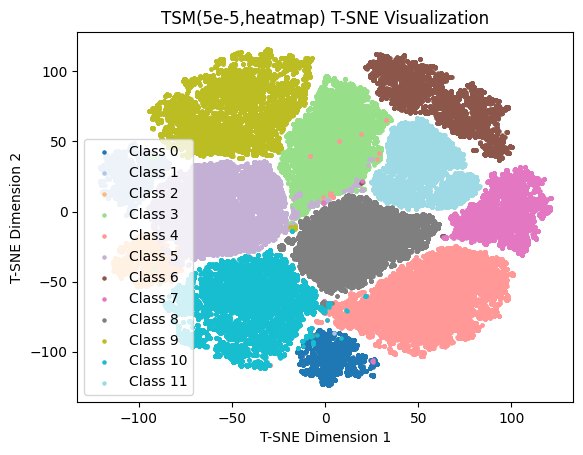

In [ ]:
# 각 클래스에 대한 고유한 색상을 정의합니다.
unique_labels = np.unique(cls)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# 각 클래스를 반복하면서 해당 클래스의 feature를 플롯합니다.
for i, label in enumerate(unique_labels):
    class_indices = np.where(cls == label)[0]
    plt.scatter(tsne_result[class_indices, 0], tsne_result[class_indices, 1], label=f'Class {label}', color=colors[i], s = 5)

# 플롯을 설정하고 레이블을 추가합니다.
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.legend(loc='best')
plt.title(f'{model_save_path.split("/")[-1]} T-SNE Visualization')
plt.show()


## 시점별 TSNE 시각화


In [ ]:
target_idx = [2,3,5]
views = [0,1,2,3,4]
idx_list = []
for cls_idx in range(len(classes)):
    for view in views:
        for idx in range(len(valid[cls_idx][view])):
            for frame in range(max(1,len(valid[cls_idx][view][idx][3])-num_frames+1)):
                idx_list.append([cls_idx,view,idx,frame])

idx_list = np.array(idx_list)
idx_list.shape

(113530, 4)

In [ ]:
# features는 T-SNE를 적용하고자 하는 특정 모델의 feature 벡터입니다.
random_state = 42

if os.path.exists(f'{model_save_path}/tsne_{random_state}.npy'):
    tsne_result = np.load(f'{model_save_path}/tsne_{random_state}.npy')
else:
    start_time = time.time()
    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_result = tsne.fit_transform(features)
    print((time.time()-start_time)/60,"분")
    np.save(f'{model_save_path}/tsne_{random_state}',tsne_result)

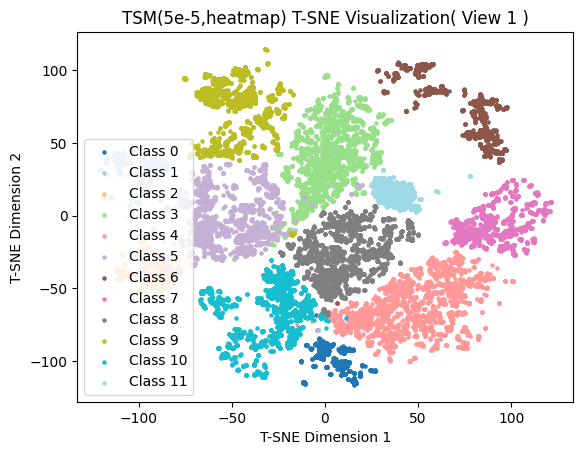

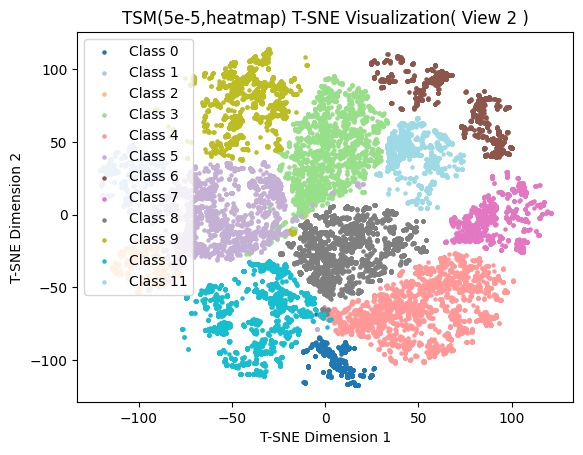

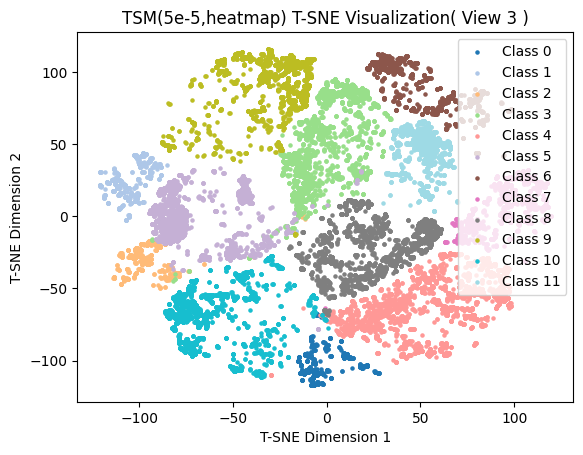

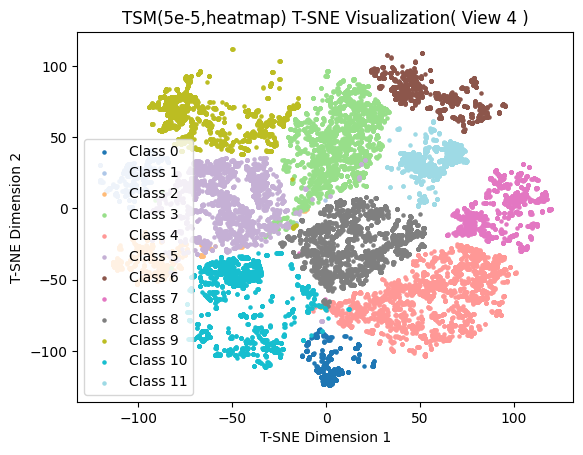

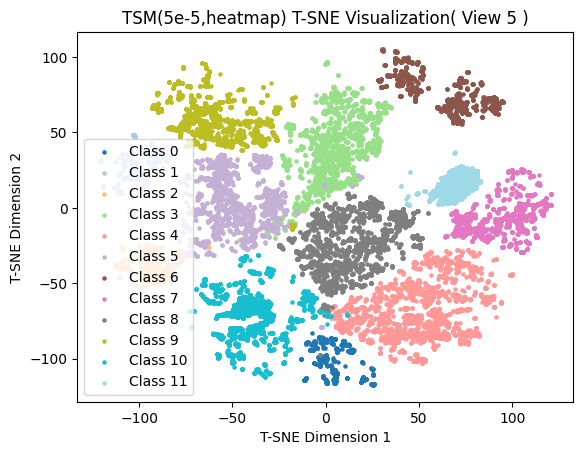

In [ ]:

for i in range(5):
    target_bool = (idx_list[:,1] == i)
    target_result = tsne_result[target_bool]
    #target_label = cls[target_bool]
    target_label = true_labels[target_bool]

    unique_labels = np.unique(target_label)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    # 각 클래스를 반복하면서 해당 클래스의 feature를 플롯합니다.
    for j, label in enumerate(unique_labels):
        class_indices = np.where(target_label == label)[0]
        plt.scatter(target_result[class_indices, 0], target_result[class_indices, 1], label=f'Class {label}', color=colors[j], s = 5)

    # 플롯을 설정하고 레이블을 추가합니다.
    plt.xlabel('T-SNE Dimension 1')
    plt.ylabel('T-SNE Dimension 2')
    plt.legend(loc='best')
    plt.title(f'{model_save_path.split("/")[-1]} T-SNE Visualization( View {i+1} )')
    plt.show()


## 세개 클래스 T- SNE 시각화

In [ ]:
random_state = 42
target_idx = [2,3,5]
target_bool = np.zeros(features.shape[0])
for t in target_idx:
    target_bool = target_bool + (idx_list[:,0] == t)
target_bool = (target_bool >= 1)


target_feature = features[target_bool]
#target_label = cls[target_bool]
target_label = true_labels[target_bool]
if os.path.exists(f'{model_save_path}/tsne_{random_state}_3cls.npy'):
    tsne_result = np.load(f'{model_save_path}/tsne_{random_state}_3cls.npy')
else:
    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_result = tsne.fit_transform(target_feature)
    np.save(f'{model_save_path}/tsne_{random_state}_3cls',tsne_result)

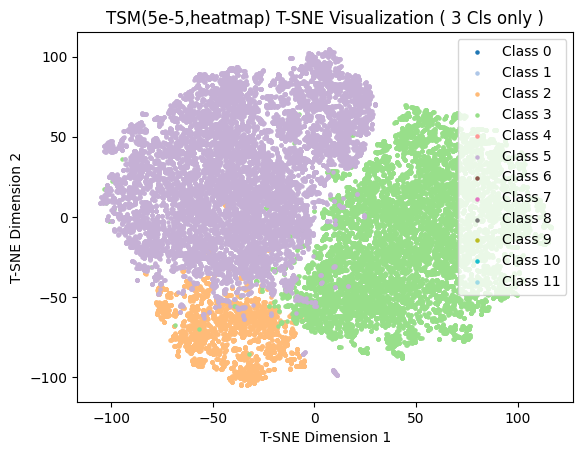

In [ ]:
# 각 클래스에 대한 고유한 색상을 정의합니다.
unique_labels = np.unique(true_labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# 각 클래스를 반복하면서 해당 클래스의 feature를 플롯합니다.
for i, label in enumerate(unique_labels):
    class_indices = np.where(target_label == label)[0]
    plt.scatter(tsne_result[class_indices, 0], tsne_result[class_indices, 1], label=f'Class {label}', color=colors[i], s = 5)

# 플롯을 설정하고 레이블을 추가합니다.
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.legend(loc='best')
plt.title(f'{model_save_path.split("/")[-1]} T-SNE Visualization ( 3 Cls only )')
plt.show()


In [ ]:
len(tsne_valid_set)

113530

In [ ]:
tsne_result.shape,target_label.shape

((30585, 2), (30585,))

In [ ]:
((tsne_result[:,0]>30) &( target_label==5)).argmax()

0

In [ ]:
sum = 0
for i in range(len(target_bool)):

    if (target_bool[i]==True):
        sum += 1
    if sum==22074:
        print(i)
        break

43168


In [ ]:
classes[3]

In [ ]:
def draw_joint(img,pts,rad=3,line=1):
    out = img.copy()
    h,w,c = img.shape
    used = np.zeros_like(point_name,dtype=np.int32())

    if torch.max(pts) <=1:
        pts = pts * torch.tensor([w,h])

    for i,se in enumerate(linked_name):
        from_xy = (int(pts[se[0]][0]),int(pts[se[0]][1]))
        to_xy = (int(pts[se[1]][0]),int(pts[se[1]][1]))

        out = cv2.line(out,from_xy,to_xy,[255,255,255],line,cv2.LINE_AA)
        if (used[se[0]]==0):
            out= cv2.circle(out,from_xy,rad,palette[se[0]],-1,cv2.LINE_AA)
            used[se[0]] = 1

        if (used[se[1]]==0):
            out= cv2.circle(out,to_xy,rad,palette[se[1]],-1,cv2.LINE_AA)
            used[se[1]] = 1

    return out

def denormalization(img, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])):

    out_img =  img * std  + mean
    return out_img

In [ ]:
tmp = tsne_valid_set[43168]

torch.Size([8, 256, 192, 3])


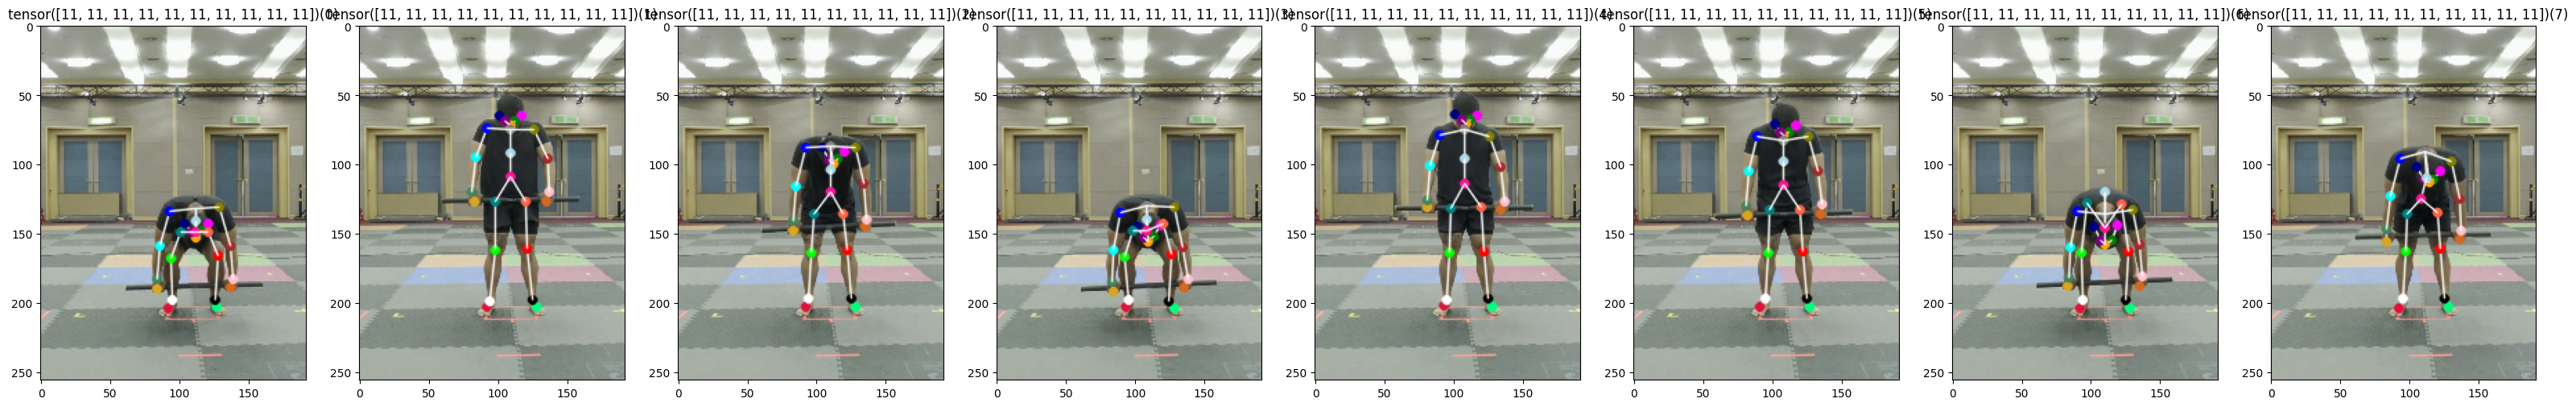

In [ ]:

img = tmp['video_heatmap'][:,:3]
heatmap = tmp['video_heatmap'][:,3:]
coord = tmp['coord']

img = np.transpose(img,(0,2,3,1))
print(img.shape)

# plt.figure(figsize=(5*num_frame,10))

# for j in range(num_frame):
#     plt.subplot(1,num_frame,j+1)
#     plt.imshow(((denormalization(img[j]))*255).numpy().astype(np.uint8()))
#     plt.title(f"{data['class']}({j})")
# plt.show()

plt.figure(figsize=(5*num_frame,10))
for j in range(num_frame):
    plt.subplot(1,num_frame,j+1)
    plt.imshow(draw_joint(((denormalization(img[j]))*255).numpy().astype(np.uint8()),torch.tensor(coord[j])))
    plt.title(f"{data['class']}({j})")
plt.show()


### 시점별 시각화

In [ ]:
idx_list[target_bool][:,1]==1

array([False, False, False, ..., False, False, False])

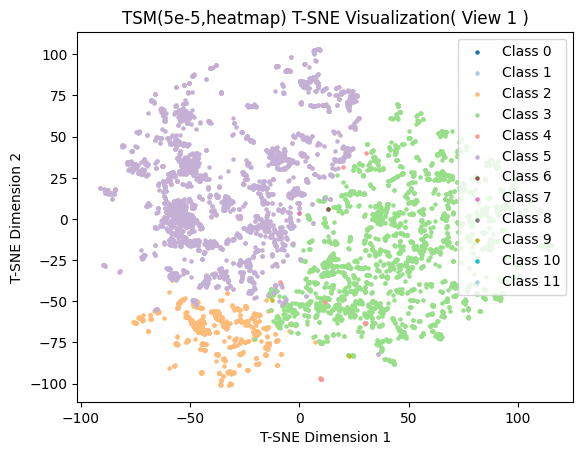

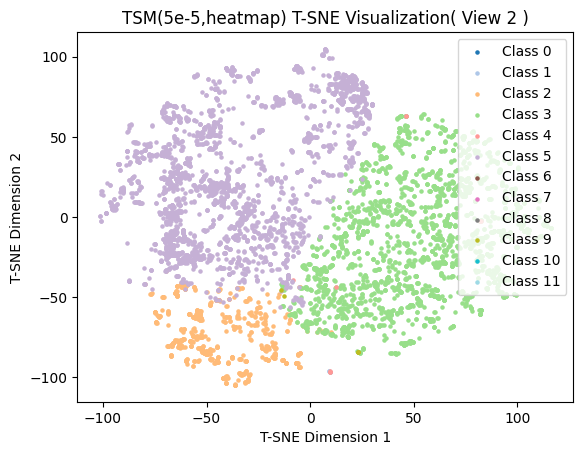

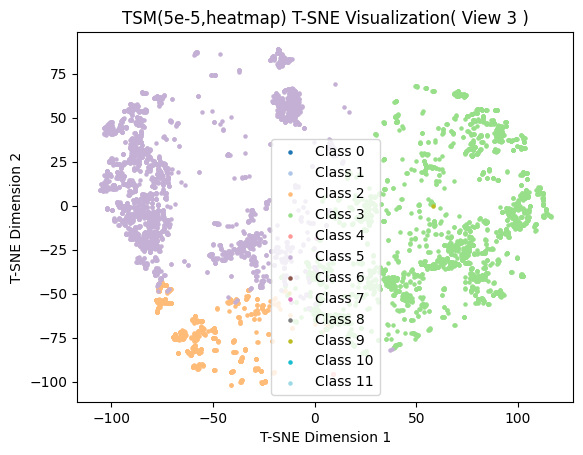

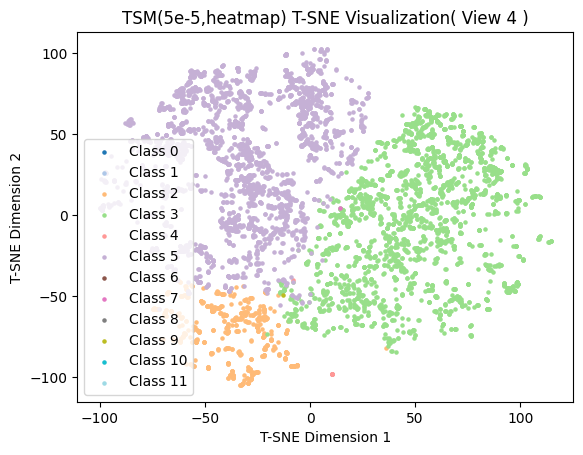

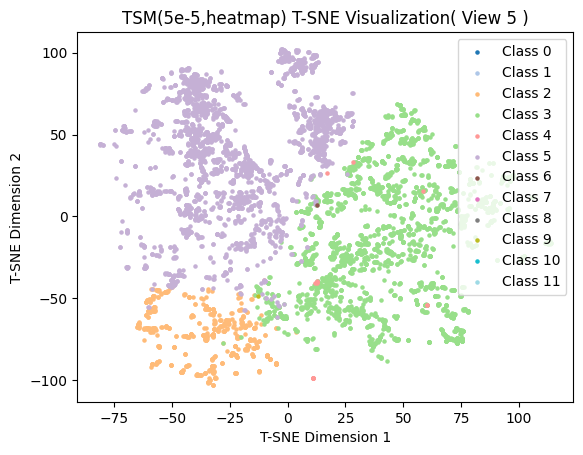

In [ ]:

for i in range(5):
    next_target_bool = (idx_list[target_bool][:,1] == i)
    target_result = tsne_result[next_target_bool]
    target_label = cls[target_bool][next_target_bool]

    unique_labels = np.unique(true_labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    # 각 클래스를 반복하면서 해당 클래스의 feature를 플롯합니다.
    for j, label in enumerate(unique_labels):
        class_indices = np.where(target_label == label)[0]
        plt.scatter(target_result[class_indices, 0], target_result[class_indices, 1], label=f'Class {label}', color=colors[j], s = 5)

    # 플롯을 설정하고 레이블을 추가합니다.
    plt.xlabel('T-SNE Dimension 1')
    plt.ylabel('T-SNE Dimension 2')
    plt.legend(loc='best')
    plt.title(f'{model_save_path.split("/")[-1]} T-SNE Visualization( View {i+1} )')
    plt.show()


# 이전 학습 상황 불러오기

In [ ]:
torch.cuda.empty_cache()
model_load_path = root_path + '/model/VC/TSM(5e-5,heatmap)/'

checkpoint = torch.load(model_load_path+f'Last6.pth','cuda')

learning_status = pd.read_csv(model_load_path+f'status.csv',index_col=0)
learning_status.iloc[:,:checkpoint['epoch']]
learning_status = learning_status.to_dict(orient='list')

model.to(device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
#scheduler.load_state_dict(checkpoint['scheduler'])

for k in learning_status.keys():
    for i in range(len(learning_status[k])):
        if k!='lrs' and k!='best':
            learning_status[k][i] = np.array([item for item in learning_status[k][i][1:-1].split(' ') if item != ''],dtype=np.float32)


min_epoch = np.argmin(np.sum(learning_status['valid_losses'],-1))

for i in range(len(learning_status['valid_metrics'])):
    print(f"Epoch:{i+1} | Train_Acc : {np.round(learning_status['train_metrics'][i],4)} | Train_Loss : {np.round(learning_status['train_losses'][i],4)}")
    print(f"Epoch:{i+1} | Valid_Acc : {np.round(learning_status['valid_metrics'][i],4)} | Valid_Loss : {np.round(learning_status['valid_losses'][i],4)}")
    print()

print(len(learning_status['lrs']),min_epoch+1,learning_status['train_metrics'][-1],learning_status['train_losses'][-1],learning_status['valid_metrics'][-1],learning_status['valid_losses'][-1],learning_status['lrs'][-1])
print(len(learning_status['lrs']),min_epoch+1,learning_status['train_metrics'][min_epoch],learning_status['train_losses'][min_epoch],learning_status['valid_metrics'][min_epoch],learning_status['valid_losses'][min_epoch],learning_status['lrs'][min_epoch])

Epoch:1 | Train_Acc : [0.7723] | Train_Loss : [0.5808]
Epoch:1 | Valid_Acc : [0.8524] | Valid_Loss : [0.4239]

Epoch:2 | Train_Acc : [0.943] | Train_Loss : [0.1578]
Epoch:2 | Valid_Acc : [0.9644] | Valid_Loss : [0.1109]

Epoch:3 | Train_Acc : [0.9623] | Train_Loss : [0.1052]
Epoch:3 | Valid_Acc : [0.9776] | Valid_Loss : [0.0667]

Epoch:4 | Train_Acc : [0.973] | Train_Loss : [0.0783]
Epoch:4 | Valid_Acc : [0.9841] | Valid_Loss : [0.0496]

Epoch:5 | Train_Acc : [0.978] | Train_Loss : [0.0639]
Epoch:5 | Valid_Acc : [0.9862] | Valid_Loss : [0.0417]

Epoch:6 | Train_Acc : [0.9813] | Train_Loss : [0.0539]
Epoch:6 | Valid_Acc : [0.9888] | Valid_Loss : [0.0368]

6 6 [0.98125756] [0.05393295] [0.98878] [0.03683534] 5e-05
6 6 [0.98125756] [0.05393295] [0.98878] [0.03683534] 5e-05
